In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import userdata
from datetime import datetime, timedelta

In [ ]:
experiments = pd.read_csv(userdata.get('EXPERIMENTS_FILE'))
experiments

,ID,USER ID,Trial ID,Target,Response,Correct,A,B,C,D
0,0,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,0,A,D,0,319,125,205,81
1,1,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,1,A,B,0,205,210,250,119
2,2,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,2,C,C,1,77,119,156,55
3,3,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,3,A,A,1,302,316,55,97
4,4,ap-northeast-1:560cdc91-0a22-4995-a7ad-0222fbc...,4,B,A,0,53,72,201,99
...,...,...,...,...,...,...,...,...,...,...
5214,5214,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,66,C,C,1,27251,27113,27194,27144
5215,5215,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,67,B,B,1,27171,27146,27100,27225
5216,5216,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,68,A,A,1,27251,27065,27117,27227
5217,5217,ap-northeast-1:32c5b4cb-812d-4fad-a087-da1bffc...,69,B,A,0,27095,27113,27144,27065


In [ ]:
m1 = pd.read_csv(userdata.get('TEMP_1'))
m1

,Unnamed: 0,Response
0,0,B. 21
1,1,A. 24
2,2,C. 2
3,3,A. 35
4,4,C. 28
...,...,...
87,87,C. 2
88,88,A. 2
89,89,B. 2
90,90,B. 2


In [ ]:
# Get participants response
uuids = experiments['USER ID'].unique()
uuid = uuids[0] #test with 1st participant

experiments_temp = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
target = experiments_temp['Target']
response = experiments_temp['Response']
experiments_offset = experiments_temp.index.min()
experiments_temp

,ID,Target,Response,Correct
0,0,A,D,0
1,1,A,B,0
2,2,C,C,1
3,3,A,A,1
4,4,B,A,0
...,...,...,...,...
87,87,C,D,0
88,88,A,A,1
89,89,C,A,0
90,90,D,D,1


In [ ]:
# Generate & Clean Model's list of response
model_response = m1['Response']
model_response_alpha = []

for res in model_response:
  model_response_alpha.append(res[0])

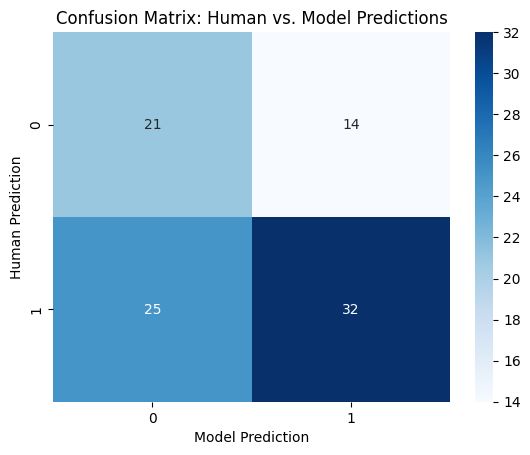

In [ ]:
# Plot CM

# Transform to binary: 1 for correct prediction, 0 for incorrect
binary_human = (response == target).astype(int)
binary_model = (model_response_alpha == target).astype(int)

# # Calculate the confusion matrix
cm1 = confusion_matrix(binary_human, binary_model)

# Plotting the confusion matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')#,
            # xticklabels=['Model Incorrect', 'Model Correct'],
            # yticklabels=['Human Incorrect', 'Human Correct'])

plt.ylabel('Human Prediction')
plt.xlabel('Model Prediction')
plt.title('Confusion Matrix: Human vs. Model Predictions')
plt.show()

In [ ]:
# Loop for running above and summing across all participants
NUM_COUNT = 66
uuids = experiments['USER ID'].unique()

hcmc_scs = 0
hwmw_dcs = 0
hwmw_scs = 0
hcmw_dcs = 0
hwmc_dcs = 0

for user in range(NUM_COUNT):

  # Get participants response
  uuid = uuids[user]
  experiments_curr = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
  target = experiments_curr['Target']
  response = experiments_curr['Response']

  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/output/responseFULLparticipant{user+1}.csv')
  model_response = m['Response']
  model_response_alpha = []
  for res in model_response:
    model_response_alpha.append(res[0])

  # Categories
  hcmc_same = ((response == target).astype(int) & (response == model_response_alpha).astype(int)).astype(int)
  hwmw_same = ((response != target).astype(int) & (response == model_response_alpha).astype(int)).astype(int)
  hwmw_diff = ((response != target).astype(int) & (model_response_alpha != target).astype(int) & (response != model_response_alpha).astype(int)).astype(int)
  hcmw_diff = ((response == target).astype(int) & (model_response_alpha != target).astype(int) & (response != model_response_alpha).astype(int)).astype(int)
  hwmc_diff = ((response != target).astype(int) & (model_response_alpha == target).astype(int) & (response != model_response_alpha).astype(int)).astype(int)

  # Counts
  _, hcmc_sc = np.unique(hcmc_same, return_counts=True)
  _, hwmw_dc = np.unique(hwmw_diff, return_counts=True)
  _, hwmw_sc= np.unique(hwmw_same, return_counts=True)
  _, hcmw_dc = np.unique(hcmw_diff, return_counts=True)
  _, hwmc_dc = np.unique(hwmc_diff, return_counts=True)

  # Add on
  hcmc_scs += hcmc_sc
  hwmw_dcs += hwmw_sc
  hwmw_scs += hwmw_sc
  hcmw_dcs += hcmw_dc
  hwmc_dcs += hwmc_dc


print(hcmc_scs, hwmw_dcs, hwmw_scs, hcmw_dcs, hwmc_dcs)

[4089 1130] [4801  557] [4801  557] [2842 2377] [4660  640]


|       |         |      | Model   |       |
|-------|---------|------|---------|-------|
|       |         |      | Correct | Wrong |
| Human | correct | same | 345     | 0     |
|       |         | diff | 0       | 341   |
|       | wrong   | same | 0       | 80    |
|       |         | diff | 93      | 80    |

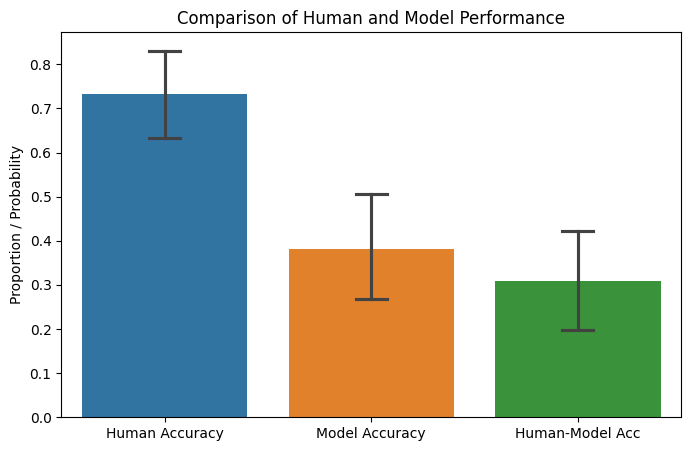

In [ ]:
# Plot bar chart

# Calculate accuracies and agreement
human_accuracy = np.mean(response == target)
model_accuracy = np.mean(model_response_alpha == target)
equivalence = np.mean(response == model_response_alpha)

series = {"Human Accuracy": pd.Series((response == target).astype(int)),
          "Model Accuracy": pd.Series((model_response_alpha == target).astype(int)),
          "Human-Model Acc": pd.Series((model_response_alpha == response).astype(int))}
df = pd.DataFrame(series)

# Data for plotting
categories = ['Human Accuracy', 'Model Accuracy', 'Equivalence']
# values = [human_accuracy, model_accuracy, equivalence]

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(data=df, errorbar=("ci", 95), capsize=.15)
# sns.barplot(x=categories, y=values, errorbar=("ci", 95))#, capsize=.2)
plt.title('Comparison of Human and Model Performance')
plt.ylabel('Proportion / Probability')
plt.show()

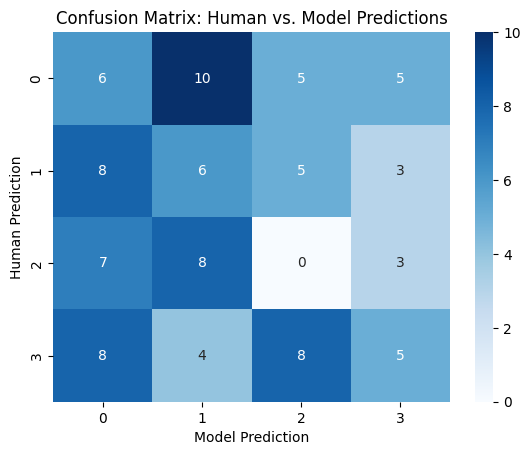

In [ ]:
# Plot (new) CM

# Calculate the confusion matrix
cm2 = confusion_matrix(response, model_response_alpha)

# Plotting the confusion matrix
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')

plt.ylabel('Human Prediction')
plt.xlabel('Model Prediction')
plt.title('Confusion Matrix: Human vs. Model Predictions')
plt.show()

In [ ]:
# Plot Extended CM

# Transform to binary: 1 for correct prediction, 0 for incorrect
binary_human = (response == target).astype(int)
binary_model = (model_response_alpha == target).astype(int)

incorrect_human = []
incorrect_model = []

both_incorrect = []
for i in range(binary_human.size):
  if (binary_human[i] == 0 and binary_model[i] == 0):
    both_incorrect.append(i)
    incorrect_human.append(response[i])
    incorrect_model.append(model_response_alpha[i])

print(len(both_incorrect) / binary_human.size)

# Calculate the confusion matrix
cm3 = confusion_matrix(incorrect_human, incorrect_model)

# Plotting the confusion matrix
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')

plt.ylabel('Wrong Human Prediction')
plt.xlabel('Wrong Model Prediction')
plt.title('When Both Human & Model Makes A Mistake:')
plt.show()

KeyError: 0

## Helpful code for formal analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import userdata
from datetime import datetime, timedelta
from scipy import stats

In [3]:
from statsmodels.discrete.conditional_models import ConditionalLogit

In [4]:
experiments = pd.read_csv(userdata.get('EXPERIMENTS_FILE'))
events = pd.read_csv(userdata.get('EVENTS_FILE'))

In [5]:
### Amended Code from gpt_remembering_events.ipynb ###

# Helpful constants
EVENT_DF, EVENT_OFFSET, EXPERIMENT_DF, EXPERIMENT_OFFSET = 0, 1, 2, 3

TEMPORAL = 0
CHOICE = 1




def create_event_experiment_dfs(uuid):
  """
  create_event_experiment_dfs() creates the appropriate dataframes and index offsets to reference events and experiments.

  :param USER_ID: the user's unique identification string
  :return: user's events, event offset index, user's experiment, experiment offset index
  """

  events_temp = events[['ID', 'StartDateTime Local', 'GPS Cluster Original']][events['USER ID']==uuid]
  experiments_temp = experiments[['ID', 'Target', 'A', 'B', 'C', 'D']][experiments['USER ID']==uuid]

  # offsets
  events_offset = events_temp.index.min()
  experiments_offset = experiments_temp.index.min()
  return (events_temp, events_offset, experiments_temp, experiments_offset)

def gen_dates(Event_Exp_df):

  events_df = Event_Exp_df[EVENT_DF]
  experiments_df = Event_Exp_df[EXPERIMENT_DF]
  experiments_offset = Event_Exp_df[EXPERIMENT_OFFSET]
  question_data = []

  # Get temporal info from each question
  for i in range(len(experiments_df)):
    response_id = experiments_df.loc[i+experiments_offset, "Target"]
    correct_event_id = experiments_df.loc[i+experiments_offset, response_id]

    # Perform lookup for experiments_df from events_df
    cluster_question = []
    for alpha in ['A', 'B', 'C', 'D']:
      alpha_response_id = experiments_df.loc[i+experiments_offset, alpha]

      choice_datetime = events_df.loc[alpha_response_id, "StartDateTime Local"]
      choice_datetime_obj = datetime.fromisoformat(choice_datetime.rstrip("Z"))

      cluster_question.append(choice_datetime_obj)

    # Datetime processing
    curr_datetime = events_df.loc[correct_event_id, "StartDateTime Local"]
    datetime_obj = datetime.fromisoformat(curr_datetime.rstrip("Z"))

    # Append all info
    question_data.append((datetime_obj, (cluster_question[0], cluster_question[1], cluster_question[2], cluster_question[3])))

  return question_data

def init_temporal_info(Event_Exp_df):
  # Pass out initial datetime

  events_df = Event_Exp_df[EVENT_DF]
  events_offset = Event_Exp_df[EVENT_OFFSET]
  location_data = []

  # Each entry is a context for GPT
  curr_datetime = events_df.loc[events_offset, "StartDateTime Local"]
  datetime_obj = datetime.fromisoformat(curr_datetime.rstrip("Z"))
  # init_date = datetime_obj.strftime("%d %B").lstrip('0')
  # init_day = datetime_obj.strftime("%A")

  return datetime_obj

def alpha_convert(alpha):
  match alpha:
    case "A":
      return 0
    case "B":
      return 1
    case "C":
      return 2
    case "D":
      return 3
    case _:
      return None

temp = create_event_experiment_dfs("ap-northeast-1:6e21924f-f2e5-40e3-ac5e-c79da47969e8")
temp_ques = gen_dates(temp)
temp_init = init_temporal_info(temp)
# temp_ques
# format = [((question: datetime), ((A: datetime), (B: datetime), (C: datetime), (D: datetime))), ...]

# T-Test Analysis

In [7]:
# P(same | error)
NUM_COUNT = 66
prob_sample = []
acc_sample = []
h_acc_sample = []
hCORRECT = 0
mCORRECT = 0
TRIALS = 0
trial_arr = []

# mean_0 = 0.25
uuids = experiments['USER ID'].unique()

for user in range(NUM_COUNT):

  model_incorrect = 0
  human_incorrect = 0

  same_given_error = 0
  incorrect_count = 0

  # Get participants response
  uuid = uuids[user]
  # print(user, uuid)
  experiments_curr = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
  targets = experiments_curr['Target']
  responses = experiments_curr['Response']
  corrects = experiments_curr['Correct']
  experiments_offset = experiments_curr.index.min()
  # print(model_response_alpha, target)

  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/output/responseFULLparticipant{user+1}.csv')
  model_response = m['Response']
  model_response_alpha = []
  for res in model_response:
    model_response_alpha.append(res[0])
  # print(len(model_response_alpha), len(targets), len(corrects))

  if (len(model_response_alpha) == len(targets)):
    for index, correct in enumerate(corrects):
      if (not correct and (model_response_alpha[index] != targets.tolist()[index])):
        incorrect_count += 1 # both incorrect
        if (model_response_alpha[index] == responses.tolist()[index]):
          # Match
          same_given_error += 1

    for q in range(len(model_response_alpha)):
      if (model_response_alpha[q] != targets.tolist()[q]):
        model_incorrect += 1

    for correct in corrects:
      if (not correct):
        human_incorrect += 1


    # Calc model accuracy
    print(f"Model:{user+1}")
    acc = (len(targets) - model_incorrect) / len(targets)
    print(f"Accuracy: {acc}")

    acc_sample.append(acc)
    mCORRECT += len(targets) - model_incorrect
    TRIALS += len(targets)
    trial_arr.append(len(targets))

    print(f"Ratio: {len(targets) - model_incorrect} correct across {len(targets)} trials")



    # Calc human acc
    h_acc = (len(targets) - human_incorrect) / len(targets)
    h_acc_sample.append(h_acc)
    hCORRECT += len(targets) - human_incorrect

    prob_sample.append(same_given_error / incorrect_count)
    # print(same_given_error, incorrect_count)

    print(f"Human:{user+1}")
    print(f"Accuracy: {h_acc}")
    print(f"Ratio: {len(targets) - human_incorrect} correct across {len(targets)} trials")
    print("-------------------------------------------\n")


  else:
    print("ERROR: NOT THE SAME LENGTH", user, len(model_response_alpha), len(targets))

  if (user == 18):
    break



print("Corr Coef betwen Number of trials and Accuracy (Model)")
print(np.corrcoef(trial_arr, acc_sample))
print("Corr Coef betwen Number of trials and Accuracy (Human)")
print(np.corrcoef(trial_arr, h_acc_sample))

# prob_sample
print(np.mean(acc_sample), len(acc_sample))
# print(np.mean(h_acc_sample))

Model:1
Accuracy: 0.34782608695652173
Ratio: 32 correct across 92 trials
Human:1
Accuracy: 0.6195652173913043
Ratio: 57 correct across 92 trials
-------------------------------------------

Model:2
Accuracy: 0.5079365079365079
Ratio: 32 correct across 63 trials
Human:2
Accuracy: 0.6666666666666666
Ratio: 42 correct across 63 trials
-------------------------------------------

Model:3
Accuracy: 0.3611111111111111
Ratio: 13 correct across 36 trials
Human:3
Accuracy: 0.5555555555555556
Ratio: 20 correct across 36 trials
-------------------------------------------

Model:4
Accuracy: 0.5569620253164557
Ratio: 44 correct across 79 trials
Human:4
Accuracy: 0.7341772151898734
Ratio: 58 correct across 79 trials
-------------------------------------------

Model:5
Accuracy: 0.7717391304347826
Ratio: 71 correct across 92 trials
Human:5
Accuracy: 0.8260869565217391
Ratio: 76 correct across 92 trials
-------------------------------------------

Model:6
Accuracy: 0.3838383838383838
Ratio: 38 correct

In [ ]:
mean_0 = 0.33
# print(CORRECT, TRIALS)
samples = prob_sample

t_score = (np.mean(samples) - mean_0) / (np.std(samples)/np.sqrt(len(samples)))
print(t_score, np.mean(samples), np.std(samples), len(samples))

2.2307567398388173 0.37064478839208825 0.14802143862153488 66


In [ ]:
print(np.mean(acc_sample))
print(np.mean(h_acc_sample))

0.37391785239041636
0.6678580454023382


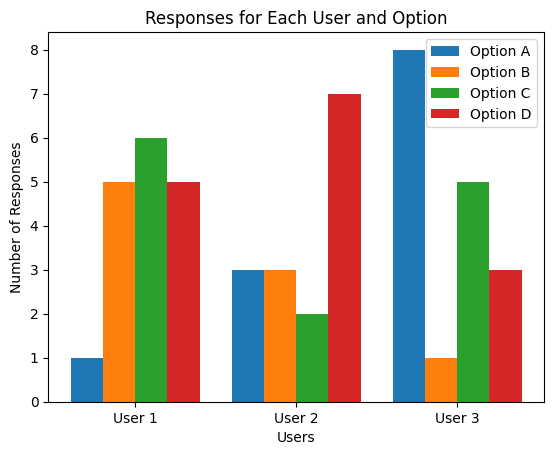

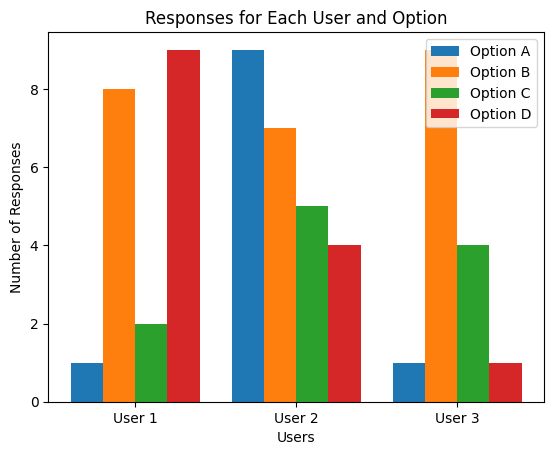

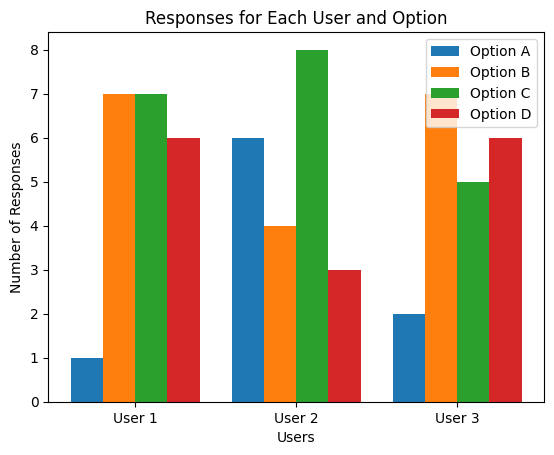

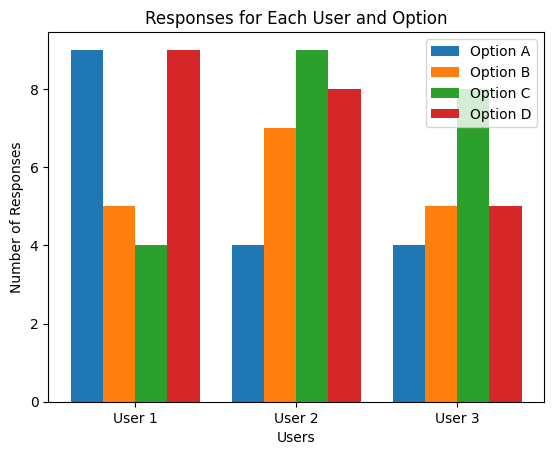

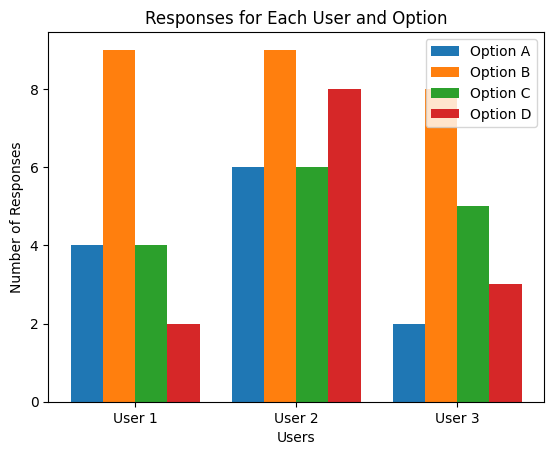

KeyboardInterrupt: 

In [73]:
uuids = experiments['USER ID'].unique()
for user in range(NUM_COUNT):

  # Get participants response
  uuid = uuids[user]
  experiments_curr = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
  target = experiments_curr['Target']
  response = experiments_curr['Response']

  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/output/responseFULLparticipant{user+1}.csv') ###
  model_response = m['Response']
  model_response_alpha = list() #np.array([])
  for res in model_response:
    model_response_alpha.append(res[0])
    # np.append(model_response_alpha, res[0])

  # Sample data (replace this with your actual data)
  users = ['User 1', 'User 2', 'User 3']
  options = ['A', 'B', 'C', 'D']

  # Random data (replace this with your actual data)
  data = np.random.randint(1, 10, size=(len(users), len(options)))

  # Plotting the bar chart
  bar_width = 0.2
  index = np.arange(len(users))

  fig, ax = plt.subplots()

  for i, option in enumerate(options):
      ax.bar(index + i * bar_width, data[:, i], bar_width, label=f'Option {option}')

  ax.set_xlabel('Users')
  ax.set_ylabel('Number of Responses')
  ax.set_title('Responses for Each User and Option')
  ax.set_xticks(index + bar_width * (len(options) - 1) / 2)
  ax.set_xticklabels(users)
  ax.legend()

  plt.show()

# Formal Analysis
1) Confusion matrix for human vs model (+ count for same/diff) <br>
2) Confusion matrix for truth against response (model and then human) on a) week b) day c) hour <br>
3) Conditional regression for a) human b) model (stretch goal)

In [74]:
# 1) Confusion matrix for human vs model (+ count for same/diff)
# NUM_COUNT = 15 #16 #66
uuids = experiments['USER ID'].unique()

hcmc_scs = 0
hwmw_dcs = 0
hwmw_scs = 0
hcmw_dcs = 0
hwmc_dcs = 0

total_trials = 0

for user in range(NUM_COUNT):

  # Get participants response
  uuid = uuids[user]
  experiments_curr = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
  target = experiments_curr['Target']
  response = experiments_curr['Response']

  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/3 - independent reworded/responseFULLparticipant{user+1}.csv') ####
  model_response = m['Response']
  model_response_alpha = list() #np.array([])
  for res in model_response:
    model_response_alpha.append(res[0])
    # np.append(model_response_alpha, res[0])

  total_trials += len(target)
  if (len(response) != len(target)):
    print("Response != Target for user:", user)
  if (len(model_response_alpha) != len(target)):
    print("Model !- Target for user:", user)


  # Categories
  hcmc_same = ((response == target).astype(int) & (response == model_response_alpha).astype(int)).astype(int)
  hwmw_same = ((response != target).astype(int) & (model_response_alpha != target).astype(int) & (response == model_response_alpha).astype(int)).astype(int) #ISSUE
  hwmw_diff = ((response != target).astype(int) & (model_response_alpha != target).astype(int) & (response != model_response_alpha).astype(int)).astype(int)
  hcmw_diff = ((response == target).astype(int) & (model_response_alpha != target).astype(int)).astype(int)
  hwmc_diff = ((response != target).astype(int) & (model_response_alpha == target).astype(int)).astype(int) #ISSUE

  # Counts
  _, hcmc_sc = np.unique(hcmc_same, return_counts=True)
  _, hwmw_dc = np.unique(hwmw_diff, return_counts=True)
  _, hwmw_sc = np.unique(hwmw_same, return_counts=True)
  _, hcmw_dc = np.unique(hcmw_diff, return_counts=True)
  _, hwmc_dc = np.unique(hwmc_diff, return_counts=True)

  # for i in [hcmc_sc, hwmw_dc, hwmw_sc, hcmw_dc, hwmc_dc]:
  #   # print(len(i))
  #   if len(i) == 1:
  #     np.append(i, 0) # assumes a list can never contain only 1s
  #     print("HERE:",i)

  if (len(hcmc_sc) == 1): hcmc_sc=np.append(hcmc_sc, 0)
  if (len(hwmw_dc) == 1): hwmw_dc=np.append(hwmw_dc, 0)
  if (len(hwmw_sc) == 1): hwmw_sc=np.append(hwmw_sc, 0)
  if (len(hcmw_dc) == 1): hcmw_dc=np.append(hcmw_dc, 0)
  if (len(hwmc_dc) == 1): hwmc_dc=np.append(hwmc_dc, 0)

  # Add on
  hcmc_scs += hcmc_sc
  hwmw_dcs += hwmw_dc
  hwmw_scs += hwmw_sc
  hcmw_dcs += hcmw_dc
  hwmc_dcs += hwmc_dc

  # print(sum(hcmc_scs) == sum(hwmw_scs))
  # print(hcmc_sc, hwmw_sc)
  # print(hcmc_scs, hwmw_scs)


  # if (user == (66-19)):
  #   print(len(response), len(model_response_alpha), len(target))
  #   print(hcmc_sc, hwmw_sc)
  #   break

# second value for number of 1s
print(hcmc_scs, hwmw_dcs, hwmw_scs, hcmw_dcs, hwmc_dcs)
# print(total_trials, type(response), type(model_response_alpha), type(target))

Model !- Target for user: 24


ValueError: ('Lengths must match to compare', (67,), (66,))

|       |         |      | Model   |       |
|-------|---------|------|---------|-------|
|       |         |      | Correct | Wrong |
| Human | correct | same | 1130    | 0     |
|       |         | diff | 0       | 2377  |
|       | wrong   | same | 0       |  557  |
|       |         | diff | 640     |  735  |

In [75]:
def relative_week(all_days):
  # Get "Today's" date to allocate each event to a relative week (0-3)
  # temporal_init = init_temporal_info(Ev_Exp_Df)

  # week0 = temporal_init
  # week1 = week0 + timedelta(days=7)
  # week2 = week1 + timedelta(days=7)
  # week3 = week2 + timedelta(days=7)

  week0 = min(all_days)
  week1 = week0 + timedelta(days=7)
  week2 = week1 + timedelta(days=7)
  week3 = week2 + timedelta(days=7)

  return [week0, week1, week2, week3]


def time_in_range_week(alpha, question, choice_flag, day_data, temporal_info, Ev_Exp_Df):
  # Determine which week a given answer belongs to
  week = relative_week(day_data)

  if (choice_flag == CHOICE):
    curr_datetime = temporal_info[question][CHOICE][alpha]#.date().isocalendar().week
  elif (choice_flag == TEMPORAL):
    curr_datetime = temporal_info[question][TEMPORAL]#.date().isocalendar().week
  else:
    print("ERROR: BAD CHOICE FLAG")
    return None

  if (week[0] <= curr_datetime < week[1]):
    return "week1"
  elif (week[1] <= curr_datetime < week[2]):
    return "week2"
  elif (week[2] <= curr_datetime < week[3]):
    print(curr_datetime)
    return "week3"
  else:
    print("ERROR: DATETIME OUTSIDE OF 4 WEEK RANGE")
    return "week4"

  # if (len(week_data==2)):
  #   # just divide it into 2 bins
  #   if (curr_week == week_data[0]):
  #     return 'week2'
  #   else:
  #     return 'week3'

  # elif (len(week_data==4)):
  #   # cant tell where the start point is so bin it into 4
  #   if (curr_week == week_data[0]):
  #     return 'week1'
  #   elif (curr_week == week_data[1]):
  #     return 'week2'
  #   elif (curr_week == week_data[2]):
  #     return 'week3'
  #   else:
  #     return 'week4'
  # else:
  #   print("ERROR: LESS THAN 2 WEEKS OF TRUTH")


# def time_in_range_week_trunc(alpha, question, choice_flag, day_data, temporal_info, Ev_Exp_Df):
#   # Determine which week a given answer belongs to
#   week = relative_week(day_data)

#   if (choice_flag == CHOICE):
#     curr_datetime = temporal_info[question][CHOICE][alpha]
#     print(alpha)
#   elif (choice_flag == TEMPORAL):
#     curr_datetime = temporal_info[question][TEMPORAL]
#   else:
#     print("ERROR: BAD CHOICE FLAG")
#     return None

#   if (week[0] <= curr_datetime < week[1]):
#     return "week1"
#   elif (week[1] <= curr_datetime < week[2]):
#     return "week2"
#   elif (week[2] <= curr_datetime < week[3]):
#     print(curr_datetime)
#     return "week3"
#   else:
#     print("ERROR: DATETIME OUTSIDE OF 4 WEEK RANGE")
#     return None

def time_in_range_day(alpha, question, choice_flag, temporal_info, Ev_Exp_Df):
  # Determine which day a given answer belongs to
  if (choice_flag == CHOICE):
    curr_datetime = temporal_info[question][CHOICE][alpha]
  elif (choice_flag == TEMPORAL):
    curr_datetime = temporal_info[question][TEMPORAL]
  else:
    print("ERROR: BAD CHOICE FLAG")
    return None

  return curr_datetime.strftime('%A')

def time_in_range_hour(alpha, question, choice_flag, temporal_info, Ev_Exp_Df):
  # Determine which day a given answer belongs to
  if (choice_flag == CHOICE):
    curr_datetime = temporal_info[question][CHOICE][alpha]
  elif (choice_flag == TEMPORAL):
    curr_datetime = temporal_info[question][TEMPORAL]
  else:
    print("ERROR: BAD CHOICE FLAG")
    return None

  return curr_datetime.strftime("%H").lstrip('0')


# time = datetime_obj.strftime("%I%p").lstrip('0')
## TO BE RAISED: why does the paper say "14 day collection period" when there's 3 weeks worth of data

In [76]:
# 2) Confusion matrix for truth against response on a) week b) day (MODEL & Human)
# NUM_COUNT = 26 #66
uuids = experiments['USER ID'].unique()

HOUR_LABEL = [str(x) for x in range(8,23)]
DAY_LABEL = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
WEEK_LABEL = ['week1','week2', 'week3']

model_week = list() # allocation of week based on choice's week (model)
human_week = list() # allocation of week based on choice's week (human)
truth_week = list() # allocation of week based on question's week

model_week_trunc = list()
human_week_trunc = list()
truth_week_trunc = list()

model_day = list() # allocation of day based on choice's day (model)
human_day = list() # allocation of day based on choice's day (human)
truth_day = list() # allocation of day based on question's day

model_hour = list() # allocation of hour based on choice's hour (model)
human_hour = list() # allocation of hour based on choice's hour (human)
truth_hour = list() # allocation of hour based on question's hour

WRONG_FLAG = False

for user in range(NUM_COUNT):

  if (user in [1, 26, 42]):
    continue

  # if user != 1:
  #   continue

  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/3 - independent reworded/responseFULLparticipant{user+1}.csv') ##### NOTE THE HARDCODING
  model_response = m['Response']
  model_response_alpha = []
  for res in model_response:
    model_response_alpha.append(res[0])

  # Get human's response
  uuid = uuids[user]
  response = experiments['Response'][experiments['USER ID']==uuid].tolist()
  target = experiments['Target'][experiments['USER ID']==uuid].tolist()

  # Get all temporal information in a given questionnaire
  ev_exp_df = create_event_experiment_dfs(uuid)
  temporal_info = gen_dates(ev_exp_df)
  # user_week = list()
  all_days = list()

  for question in range(len(response)):
    # Get the existing weeks in the questionnaire
    # user_week.append(temporal_info[question][TEMPORAL].date().isocalendar().week)
    curr_alpha_m = alpha_convert(model_response_alpha[question])
    curr_alpha_h = alpha_convert(response[question])

    all_days.append(temporal_info[question][TEMPORAL])#.date())
    all_days.append(temporal_info[question][CHOICE][curr_alpha_m])#.date())
    all_days.append(temporal_info[question][CHOICE][curr_alpha_h])#.date())


  for question in range(len(response)):

    if (WRONG_FLAG):
      # Only counts when both human and model makes an error
      if (response[question] == target[question] or (model_response_alpha[question] == target[question])):
        continue

    # Allocate truth (based on question)
    truth_week.append(time_in_range_week(None, question, TEMPORAL, all_days, temporal_info, ev_exp_df))
    truth_day.append(time_in_range_day(None, question, TEMPORAL, temporal_info, ev_exp_df))
    truth_hour.append(time_in_range_hour(None, question, TEMPORAL, temporal_info, ev_exp_df))

    # Allocate model (based on model choice)
    curr_alpha_m = alpha_convert(model_response_alpha[question])
    model_week.append(time_in_range_week(curr_alpha_m, question, CHOICE, all_days, temporal_info, ev_exp_df))
    model_day.append(time_in_range_day(curr_alpha_m, question, CHOICE, temporal_info, ev_exp_df))
    model_hour.append(time_in_range_hour(curr_alpha_m, question, CHOICE, temporal_info, ev_exp_df))

    # Allocate human (based on human choice)
    curr_alpha_h = alpha_convert(response[question])
    human_week.append(time_in_range_week(curr_alpha_h, question, CHOICE, all_days, temporal_info, ev_exp_df))
    human_day.append(time_in_range_day(curr_alpha_h, question, CHOICE, temporal_info, ev_exp_df))
    human_hour.append(time_in_range_hour(curr_alpha_h, question, CHOICE, temporal_info, ev_exp_df))

  print(user, max(all_days)-min(all_days))


0 13 days, 5:00:00
2 11 days, 4:00:00
3 13 days, 13:00:00
4 13 days, 11:00:00


TypeError: tuple indices must be integers or slices, not NoneType

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

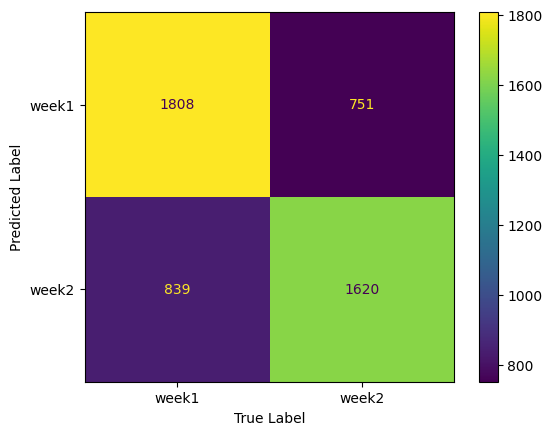

In [ ]:
WEEK_LABEL2 = ['week1', 'week2']
model_conf_week = confusion_matrix(model_week, truth_week, labels=WEEK_LABEL2)
mw_plt = ConfusionMatrixDisplay(model_conf_week, display_labels=WEEK_LABEL2)
mw_plt.plot()
mw_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

2647, 2371
0.3169 0.316

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

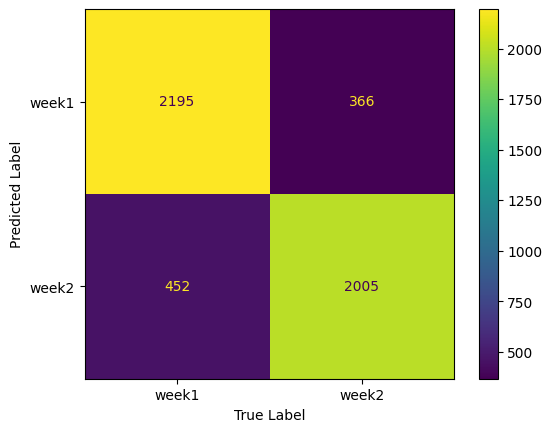

In [ ]:
human_conf_week = confusion_matrix(human_week, truth_week, labels=WEEK_LABEL2)
hw_plt = ConfusionMatrixDisplay(human_conf_week, display_labels=WEEK_LABEL2)
hw_plt.plot()
hw_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

2647, 2371
0.171, 0.154

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

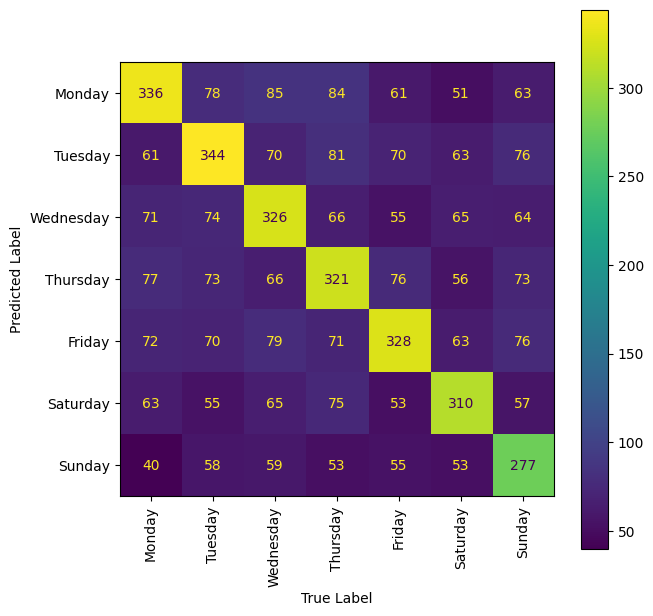

In [ ]:
model_conf_day = confusion_matrix(model_day, truth_day, labels=DAY_LABEL)
md_plt = ConfusionMatrixDisplay(model_conf_day, display_labels=DAY_LABEL)

fig, ax = plt.subplots(figsize=(7,7))
md_plt.plot(ax=ax, xticks_rotation='vertical')
md_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

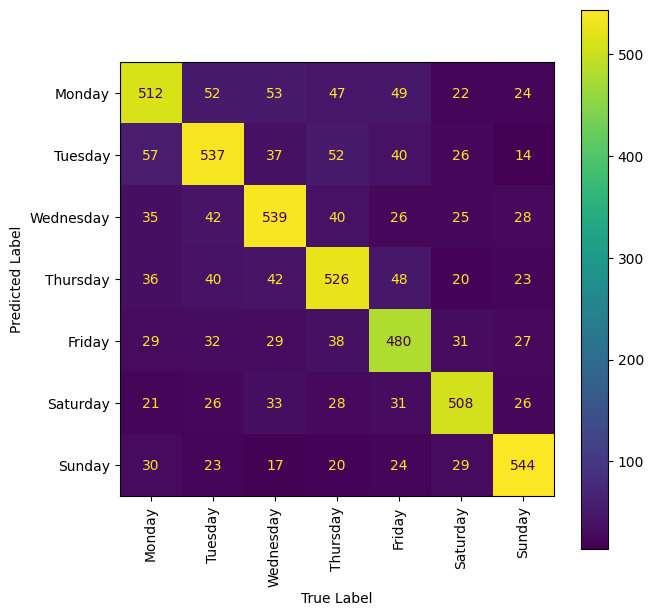

In [ ]:
human_conf_day = confusion_matrix(human_day, truth_day, labels=DAY_LABEL)
hd_plt = ConfusionMatrixDisplay(human_conf_day, display_labels=DAY_LABEL)

fig, ax = plt.subplots(figsize=(7,7))
hd_plt.plot(ax=ax, xticks_rotation='vertical')
hd_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

# hd_plt.plot()

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

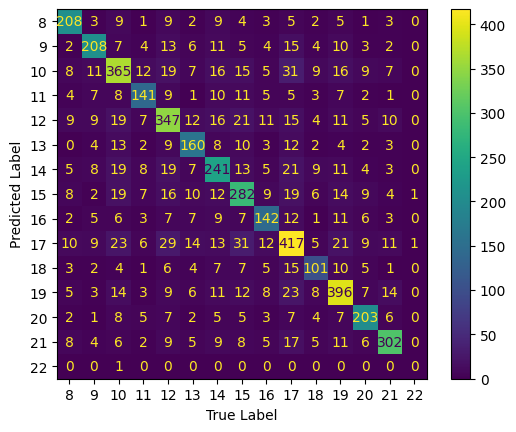

In [ ]:
human_conf_hour = confusion_matrix(human_hour, truth_hour, labels=HOUR_LABEL)
hh_plt = ConfusionMatrixDisplay(human_conf_hour, display_labels=HOUR_LABEL)
hh_plt.plot()
hh_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

[Text(0.5, 0, 'True Label'), Text(0, 0.5, 'Predicted Label')]

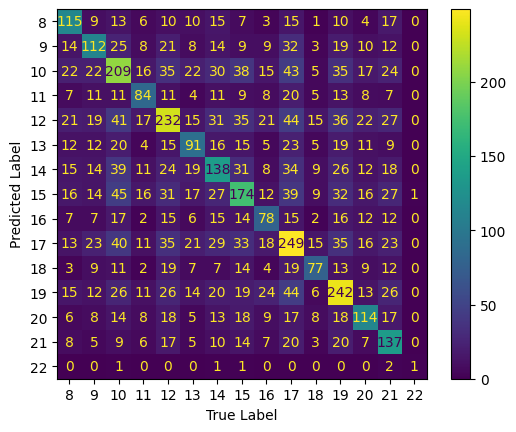

In [ ]:
model_conf_hour = confusion_matrix(model_hour, truth_hour, labels=HOUR_LABEL)
mh_plt = ConfusionMatrixDisplay(model_conf_hour, display_labels=HOUR_LABEL)

mh_plt.plot()
mh_plt.ax_.set(xlabel='True Label', ylabel='Predicted Label')

# Separate analysis on the GPT Accuracy


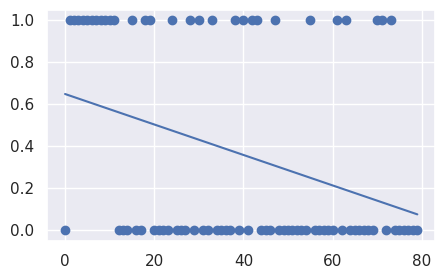

Slope: -0.007255039849976559


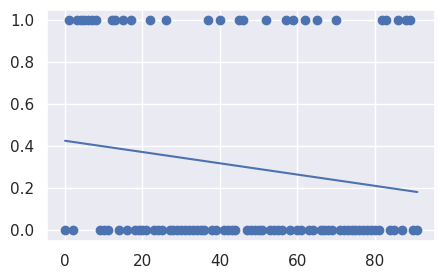

Slope: -0.002681750227332275


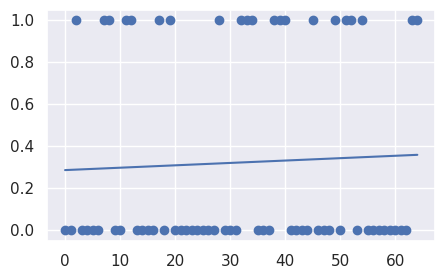

Slope: 0.0011363636363636365


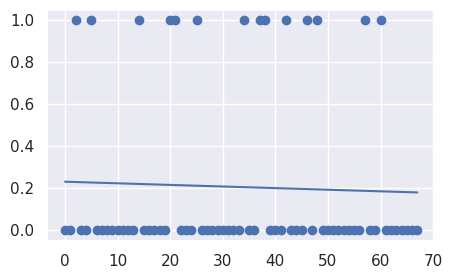

Slope: -0.0007634461961293279


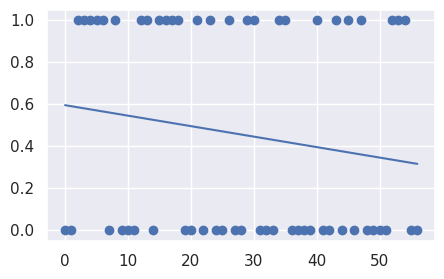

Slope: -0.004990925589836661


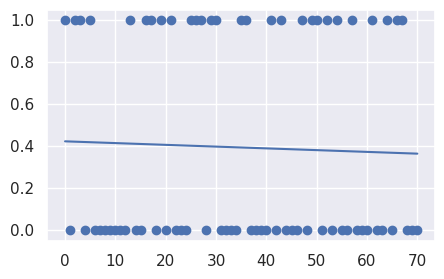

Slope: -0.0008383635144198528


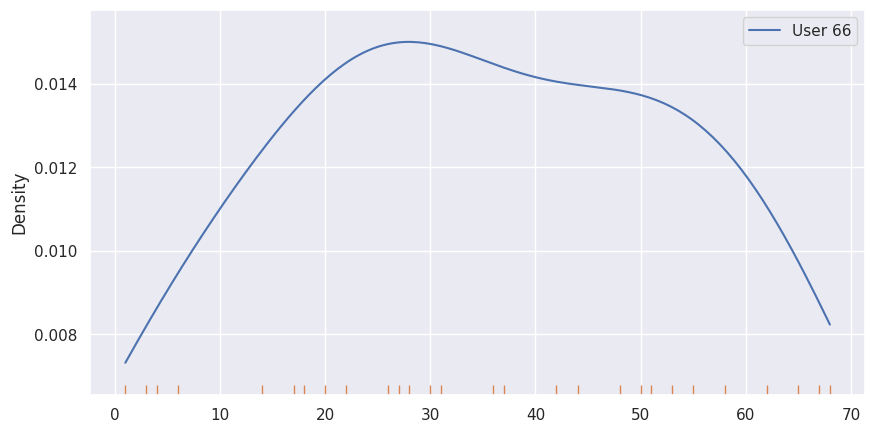

In [ ]:
sns.set(rc={'figure.figsize':(5,3)})

for user in range(NUM_COUNT):
  # Get model's response
  m = pd.read_csv(f'/content/drive/MyDrive/episodic-GPT-research/output/responseFULLparticipant{user+1}.csv')
  model_response = m['Response']
  model_response_alpha = []
  for res in model_response:
    model_response_alpha.append(res[0])

  # Get human's response
  uuid = uuids[user]
  response = experiments['Response'][experiments['USER ID']==uuid]
  target = experiments['Target'][experiments['USER ID']==uuid]

  if (user < 60):
    continue

  x = [i for i in range(len(target))]
  y = (model_response_alpha == target).astype(int)



  slope, intercept, r, p, std_err = stats.linregress(x, y)

  def myfunc(x):
    return slope * x + intercept

  mymodel = list(map(myfunc, x))

  plt.scatter(x, y)
  plt.plot(x, mymodel)
  plt.show()
  print(f"Slope: {slope}")


# dfy = pd.DataFrame(y).reset_index()

sns.set(rc={'figure.figsize':(10,5)})
plot = []
for count, correct in enumerate(y):
  if (correct):
    plot.append(count+1)
sns.kdeplot(plot, cut=0, label="User "+ str(user+1))
sns.rugplot(plot)
plt.legend()


# print(dfy.reset_index())

[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
[0.75, 0.625, 0.375, 0.25, 0.5, 0.375, 0.125, 0.125, 0.2857142857142857]


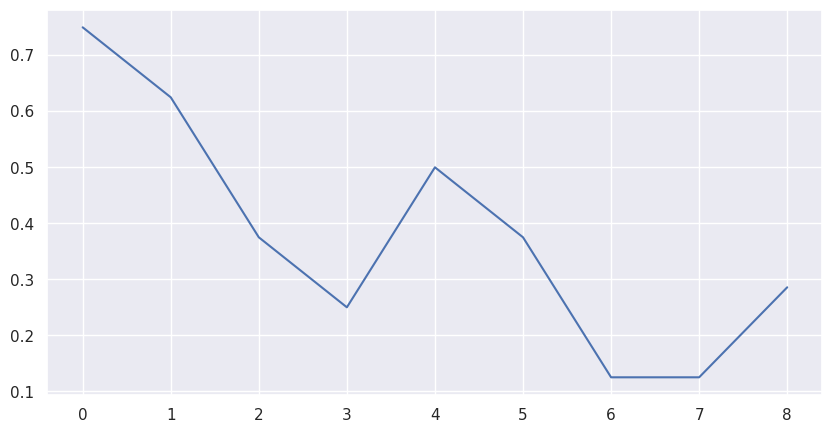

In [ ]:
bin = 8
acc = []
count = 0

if (type(y) != list):
  y = y.tolist()
print(y)

for i in range(0,len(y), bin):

  temp = []

  if (len(y) - count - bin < 0):
    # print(len(y), count, len(y) - count)
    # bin whatever's left
    for j in range(count, len(y)):
      temp.append(y[j])
    acc.append(np.mean(temp))
  else:
    for j in range(count, count+bin):
      temp.append(y[j])
    acc.append(np.mean(temp))

  count += bin

print(acc)


plt.plot(acc)

#Presentation Calculations

In [63]:
# P(same | error)
NUM_COUNT = 66
prob_sample = []
acc_sample = []
h_acc_sample = []
hCORRECT = 0
mCORRECT = 0
TRIALS = 0
trial_arr = []

# mean_0 = 0.25
uuids = experiments['USER ID'].unique()

for user in range(NUM_COUNT):

  file1 = f'/content/drive/MyDrive/episodic-GPT-research/1 - non dependent output/responseFULLparticipant{user+1}.csv'
  file2 = f'/content/drive/MyDrive/episodic-GPT-research/2 - independent 0 shot/responseFULLparticipant{user+1}.csv'
  file3 = f'/content/drive/MyDrive/episodic-GPT-research/3 - independent reworded/responseFULLparticipant{user+1}.csv'
  file4 = f'/content/drive/MyDrive/episodic-GPT-research/output/responseFULLparticipant{user+1}.csv'

  model_incorrect = 0
  human_incorrect = 0

  same_given_error = 0
  incorrect_count = 0

  # Get participants response
  uuid = uuids[user]
  # print(user, uuid)
  experiments_curr = experiments[['ID', 'Target', 'Response', 'Correct']][experiments['USER ID']==uuid]
  targets = experiments_curr['Target']
  responses = experiments_curr['Response']
  corrects = experiments_curr['Correct']
  experiments_offset = experiments_curr.index.min()
  # print(model_response_alpha, target)

  # Get model's response
  m = pd.read_csv(file4) ## CHANGE HERE
  model_response = m['Response']
  model_response_alpha = []
  for res in model_response:
    model_response_alpha.append(res[0])
  # print(len(model_response_alpha), len(targets), len(corrects))

  if (len(model_response_alpha) == len(targets)):
    for index, correct in enumerate(corrects):
      if (not correct and (model_response_alpha[index] != targets.tolist()[index])):
        incorrect_count += 1 # both incorrect
        if (model_response_alpha[index] == responses.tolist()[index]):
          # Match
          same_given_error += 1

    for q in range(len(model_response_alpha)):
      if (model_response_alpha[q] != targets.tolist()[q]):
        model_incorrect += 1

    for correct in corrects:
      if (not correct):
        human_incorrect += 1


    # Calc model accuracy
    # print(f"Model:{user+1}")
    acc = (len(targets) - model_incorrect) / len(targets)
    # print(f"Accuracy: {acc}")

    acc_sample.append(acc)
    mCORRECT += len(targets) - model_incorrect
    TRIALS += len(targets)
    trial_arr.append(len(targets))

    # print(f"Ratio: {len(targets) - model_incorrect} correct across {len(targets)} trials")



    # Calc human acc
    h_acc = (len(targets) - human_incorrect) / len(targets)
    h_acc_sample.append(h_acc)
    hCORRECT += len(targets) - human_incorrect

    prob_sample.append(same_given_error / incorrect_count)
    # print(same_given_error, incorrect_count)

    # print(f"Human:{user+1}")
    # print(f"Accuracy: {h_acc}")
    # print(f"Ratio: {len(targets) - human_incorrect} correct across {len(targets)} trials")
    # print("-------------------------------------------\n")


  # else:
    # print("ERROR: NOT THE SAME LENGTH", user, len(model_response_alpha), len(targets))



print(np.mean(prob_sample), len(prob_sample), np.std(prob_sample))
# print(np.mean(acc_sample), len(acc_sample), np.std(acc_sample))
# print(np.mean(h_acc_sample))

0.3960890309483522 62 0.14716951496005976


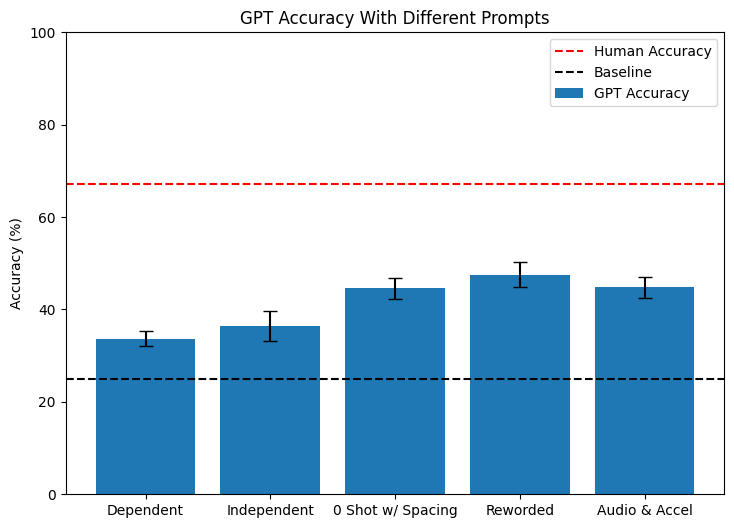

In [71]:
# Sample data: values and confidence intervals
values = [33.62, 36.37, 44.58, 47.56, 44.80]
confidence_intervals = [1.62, 3.25, 2.268, 2.763, 2.265]  # Assuming symmetric intervals for simplicity
human = 67.16
baseline = 25

# Calculate upper and lower bounds for error bars
lower_bounds = [value - ci for value, ci in zip(values, confidence_intervals)]
upper_bounds = [value + ci for value, ci in zip(values, confidence_intervals)]

# Bar positions
positions = np.arange(len(values))

# Plotting
plt.figure(figsize=(8.5, 6))
plt.bar(positions, values, yerr=confidence_intervals, capsize=5, label='GPT Accuracy')
plt.axhline(y=human, color='r', linestyle='--', label='Human Accuracy')
plt.axhline(y=baseline, color='k', linestyle='--', label='Baseline')

# Adding labels and title

# plt.xlabel('Bars')
plt.ylabel('Accuracy (%)')
plt.title('GPT Accuracy With Different Prompts')
plt.legend()

plt.xticks(positions, ['Dependent', 'Independent', '0 Shot w/ Spacing', 'Reworded', 'Audio & Accel'])
plt.ylim(0, 100)

# Show the plot
plt.show()

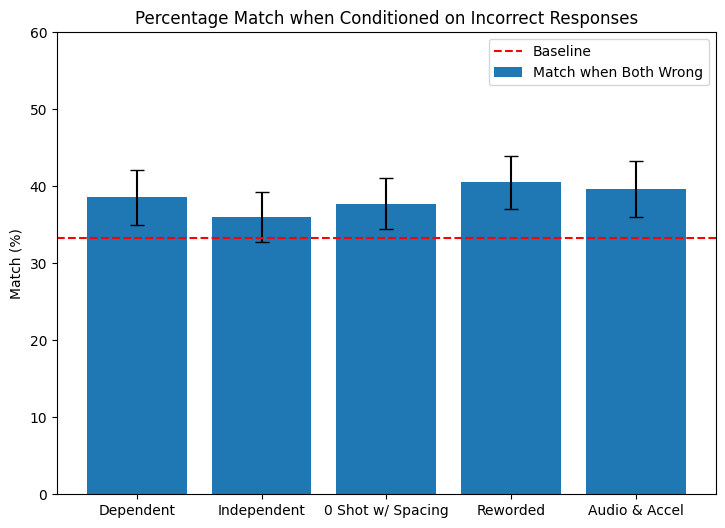

In [69]:
# Sample data: values and confidence intervals
values = [38.57, 36.04, 37.75, 40.5, 39.61]
confidence_intervals = [3.56, 3.25, 3.303, 3.448, 3.664]  # Assuming symmetric intervals for simplicity
benchmark = 33.33

# Calculate upper and lower bounds for error bars
lower_bounds = [value - ci for value, ci in zip(values, confidence_intervals)]
upper_bounds = [value + ci for value, ci in zip(values, confidence_intervals)]

# Bar positions
positions = np.arange(len(values))

# Plotting
plt.figure(figsize=(8.5, 6))
plt.bar(positions, values, yerr=confidence_intervals, capsize=5, label='Match when Both Wrong')
plt.axhline(y=benchmark, color='r', linestyle='--', label='Baseline')

# Adding labels and title

# plt.xlabel('Bars')
plt.ylabel('Match (%)')
plt.title('Percentage Match when Conditioned on Incorrect Responses')
plt.legend()

plt.xticks(positions, ['Dependent', 'Independent', '0 Shot w/ Spacing', 'Reworded', 'Audio & Accel'])
plt.ylim(0, 60)

# Show the plot
plt.show()